# Modeling for infection diagnosis

## Import NLP model & Python libraries

In [ ]:
# Load the en_ner_bc5cdr_md model
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import spacy
import torch.optim as optim
import os
from gensim.models import Word2Vec
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm
tqdm.pandas()  # Enable progress bar for pandas (change apply to progress_apply)


## Constants and Data Loading


In [2]:
MIMIC_3_DIR = '../mimic/mimic-iii-clinical-database-1.4'
os.chdir(MIMIC_3_DIR)

# Get data & apply lowercase to column names
diagnoses_df = pd.read_csv('DIAGNOSES_ICD.csv').set_index('ROW_ID').rename(columns=lambda x: x.lower())
notes_df = pd.read_csv('NOTEEVENTS.csv', low_memory=False).set_index('ROW_ID').rename(columns=lambda x: x.lower())
diagnoses_labels_df = pd.read_csv('D_ICD_DIAGNOSES.csv').set_index('ROW_ID').rename(columns=lambda x: x.lower())
patients_df = pd.read_csv('PATIENTS.csv').set_index('ROW_ID').rename(columns=lambda x: x.lower())

## Drop duplicates


In [3]:
# Keep only unique
diagnoses_df = diagnoses_df.drop_duplicates()
notes_df = notes_df.drop_duplicates()
diagnoses_labels_df = diagnoses_labels_df.drop_duplicates()
patients_df = patients_df.drop_duplicates()

## Get & set patient ages for later analysis

In [ ]:
# Calculate age function
def calculate_age(dob, dod):
    if pd.isna(dod):
        return None
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    return (dod_date - dob_date).days // 365

# Apply calculate_age and filter
patients_df['age'] = patients_df.apply(lambda row: calculate_age(row['dob'], row['dod']), axis=1)
filtered_patients_df = patients_df[patients_df['age'] < 120]  # Filter unrealistic ages

# Normalize age & fill missing values with mean
scaler_age = StandardScaler()
filtered_patients_df["normalized_age"] = scaler_age.fit_transform(filtered_patients_df["age"].values.reshape(-1, 1))
filtered_patients_df["normalized_age"].fillna(filtered_patients_df["normalized_age"].mean(), inplace=True)

<Axes: >

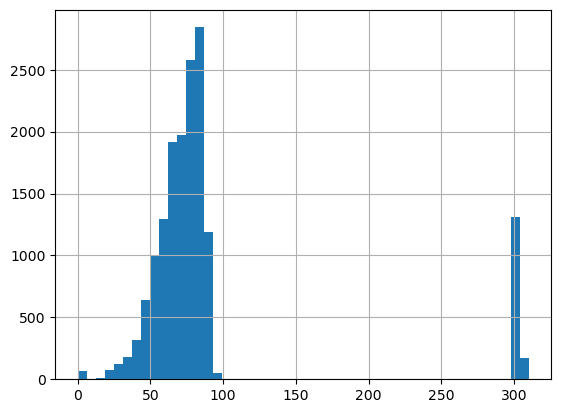

In [5]:
patients_df['age'].hist(bins=50)

<Axes: >

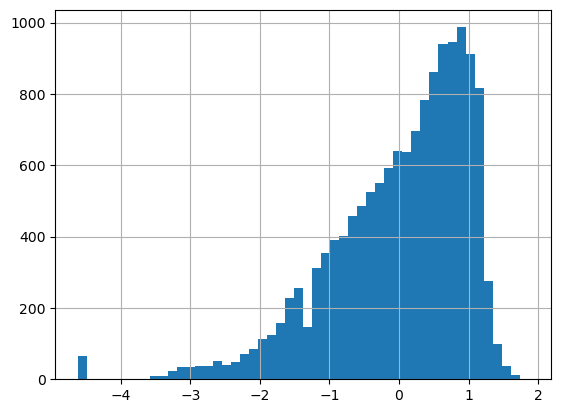

In [6]:
filtered_patients_df['normalized_age'].hist(bins=50)

## Find most common patient infection diagnoses

In [ ]:
# merge diagnoses_df with diagnoses_labels_df
diagnoses_labels_n_codes_df = diagnoses_df.merge(diagnoses_labels_df, on='icd9_code', how='inner')

# combine patients_df with diagnoses_labels_n_codes_df
patient_diagnoses_df = filtered_patients_df.merge(diagnoses_labels_n_codes_df, on='subject_id', how='inner')   

# find most common diagnoses
print(patient_diagnoses_df['short_title'].value_counts().head(20))

short_title
Hypertension NOS            7454
CHF NOS                     7031
Atrial fibrillation         6331
Acute kidney failure NOS    4805
Crnry athrscl natve vssl    4508
Acute respiratry failure    4420
DMII wo cmp nt st uncntr    4076
Urin tract infection NOS    3308
Pneumonia, organism NOS     2669
Chr airway obstruct NEC     2529
Hyperlipidemia NEC/NOS      2508
Severe sepsis               2363
Acidosis                    2343
Septicemia NOS              2282
Hypothyroidism NOS          2114
Pure hypercholesterolem     2103
Anemia NOS                  2085
Food/vomit pneumonitis      2021
Esophageal reflux           1995
Ac posthemorrhag anemia     1749
Name: count, dtype: int64


## Map infections

In [ ]:
# Common blood infection codes
infection_codes = ['5990', '486', '99592', '0389']
# Filter for only infection codes
infection_df = patient_diagnoses_df[patient_diagnoses_df['icd9_code'].isin(infection_codes)].copy()

infection_types = {  
    "5990": "Urin tract infection NOS",
    "486": "Pneumonia, organism NOS",
    "99592": "Severe sepsis",
    "0389": "Septicemia NOS"
}

# Map infection types to infection codes
infection_df['infection_type'] = infection_df['icd9_code'].map(infection_types)

In [111]:
infection_df.head()
infection_df.shape

(10622, 15)

## Merge and process Infection, Notes, & Patients dataframes

In [135]:
# merge notes with infection data
data_df = pd.merge(infection_df, notes_df, on='subject_id', how='inner')

# Keep only relevant features from merged data
data_df = data_df[['subject_id', 'infection_type', 'text', 'gender', 'expire_flag', 'age', 'normalized_age']]

# Drop rows with missing age
data_df.dropna(subset=['age'], inplace=True)
 

In [118]:
data_df.shape
data_df.head()

,subject_id,infection_type,text,gender,expire_flag,age,normalized_age,doc_vector
76918,1578,Urin tract infection NOS,[**2137-8-15**] 4:53 PM\n CHEST (PORTABLE AP) ...,F,1,80.0,0.672780,"[0.24923335, 0.14399436, 0.15486188, -0.022939..."
1059043,89797,Urin tract infection NOS,[**2161-1-29**] 3:58 PM\n CHEST PORT. LINE PLA...,F,1,66.0,-0.253160,"[0.29963365, 0.14298423, 0.1482959, -0.0240202..."
941025,30637,Urin tract infection NOS,Sinus rhythm. Possible inferior wall myocardi...,M,1,56.0,-0.914546,"[-0.036407843, 0.02370421, 0.054033894, 0.0480..."
392227,21280,"Pneumonia, organism NOS",Sinus rhythm\n - first degree A-V block\nPossi...,M,1,49.0,-1.377515,"[-0.0952611, 0.05301283, -0.0047803987, 0.0733..."
47275,2378,"Pneumonia, organism NOS",TITLE:\n Chief Complaint:\n HPI: This is a...,F,1,82.0,0.805057,"[-0.021310138, 0.026364667, 0.07288488, 0.0102..."


## NLP functions

In [131]:
# Load specified model (spacy/scispacy/bert)
def load_nlp_model(model_name="en_ner_bc5cdr_md"): # Default bert
    try:
        return spacy.load(model_name) # Loads specified model.
    except OSError:
        raise ValueError(f"Could not load model '{model_name}'. Make sure it is installed.")

# Function to get vectors in bulk
def extract_doc_vectors(texts, batch_size=100):
    nlp = spacy.load("en_ner_bc5cdr_md", disable=["parser"])
    return np.array([doc.vector for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Extracting Doc Vectors")])

## Due to dataset size, randomly select 10% for processing

In [136]:
data_df = data_df.sample(frac=0.01, random_state=42)

In [137]:
# Generate vectors for all documents
data_df["doc_vector"] = list(extract_doc_vectors(data_df["text"].tolist()))

Extracting Doc Vectors: 100%|██████████| 12202/12202 [12:22<00:00, 16.44it/s]


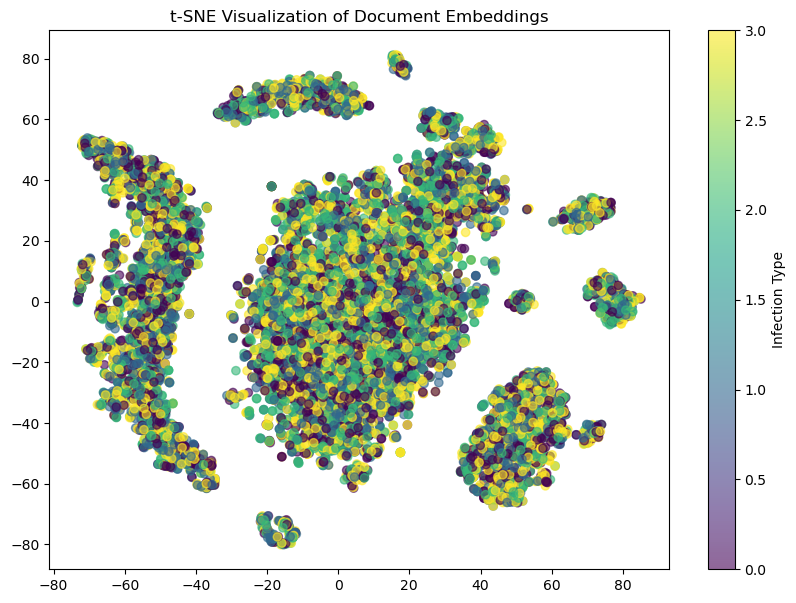

In [143]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data_df['infection_type'])

tsne = TSNE(n_components=2, random_state=42)
doc_vectors_2d = tsne.fit_transform(np.array(data_df['doc_vector'].tolist()))

plt.figure(figsize=(10, 7))
scatter = plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Infection Type")
plt.title("t-SNE Visualization of Document Embeddings")
plt.show()


In [145]:
# show labels
label_encoder.classes_

array(['Pneumonia, organism NOS', 'Septicemia NOS', 'Severe sepsis',
       'Urin tract infection NOS'], dtype=object)

In [ ]:
data_df.head()

,subject_id,infection_type,text,gender,expire_flag,age,normalized_age,doc_vector
76918,1578,Urin tract infection NOS,[**2137-8-15**] 4:53 PM\n CHEST (PORTABLE AP) ...,F,1,80.0,0.672780,"[0.24923335, 0.14399436, 0.15486188, -0.022939..."
1059043,89797,Urin tract infection NOS,[**2161-1-29**] 3:58 PM\n CHEST PORT. LINE PLA...,F,1,66.0,-0.253160,"[0.29963365, 0.14298423, 0.1482959, -0.0240202..."
941025,30637,Urin tract infection NOS,Sinus rhythm. Possible inferior wall myocardi...,M,1,56.0,-0.914546,"[-0.036407843, 0.02370421, 0.054033894, 0.0480..."
392227,21280,"Pneumonia, organism NOS",Sinus rhythm\n - first degree A-V block\nPossi...,M,1,49.0,-1.377515,"[-0.0952611, 0.05301283, -0.0047803987, 0.0733..."
47275,2378,"Pneumonia, organism NOS",TITLE:\n Chief Complaint:\n HPI: This is a...,F,1,82.0,0.805057,"[-0.021310138, 0.026364667, 0.07288488, 0.0102..."


In [126]:
# nlp = load_nlp_model("en_core_sci_md")

nlp = spacy.load("en_ner_bc5cdr_md")

corpus = []
corpus_df = data_df.sample(frac=0.0001, random_state=42)

for idx, row in corpus_df.iterrows():
    doc = nlp(row['text'])
    print("doc", doc)
    entities = [ent.text for ent in doc.ents]
    corpus.append(entities)

# Check sample
for i, entities in enumerate(corpus[:5]):
    print(f"Document {i+1}: {entities}")

doc Chief Complaint:
   24 Hour Events:
   - tolerating PS with back up MMV
   - waiting on placement & better pain control
   Allergies:
   Bactrim (Oral) (Sulfamethoxazole/Trimethoprim)
   Rash;
   Remeron (Oral) (Mirtazapine)
   Unknown;
   Last dose of Antibiotics:
   Meropenem - [**2185-4-8**] 08:15 AM
   Vancomycin - [**2185-4-11**] 01:51 AM
   Infusions:
   Other ICU medications:
   Morphine Sulfate - [**2185-4-11**] 05:39 AM
   Other medications:
   Flowsheet Data as of  [**2185-4-11**] 07:13 AM
   Vital signs
   Hemodynamic monitoring
   Fluid balance
                                                                  24 hours
                                                               Since 12 AM
   Tmax: 37.1
C (98.8
   Tcurrent: 36.8
C (98.2
   HR: 90 (68 - 97) bpm
   BP: 164/71(90) {120/56(75) - 189/110(113)} mmHg
   RR: 14 (12 - 26) insp/min
   SpO2: 98%
   Heart rhythm: AF (Atrial Fibrillation)
   Wgt (current): 60 kg (admission): 64 kg
   Height: 69 Inch
             T

In [127]:
# count of unique entities
unique_entities = set([entity for entities in corpus for entity in entities])
print(f"Number of unique entities: {len(unique_entities)}")

Number of unique entities: 186


## tSNE function

In [128]:
from sklearn.cluster import KMeans
import random

def tsne_plot(model, words, preTrained=False, max_words=100, n_clusters=5):
    "Creates and TSNE model and plots it with K-Means clustering"
    labels = []
    tokens = []

    # Sample a subset of words if there are too many
    if len(words) > max_words:
        words = random.sample(words, max_words)

    for word in words:
        if preTrained:
            tokens.append(model[word])
        else:
            tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=5, early_exaggeration=50, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=23)
    kmeans.fit(new_values)
    cluster_labels = kmeans.labels_

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=colors[cluster_labels[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

## Plot entity proximity relationships

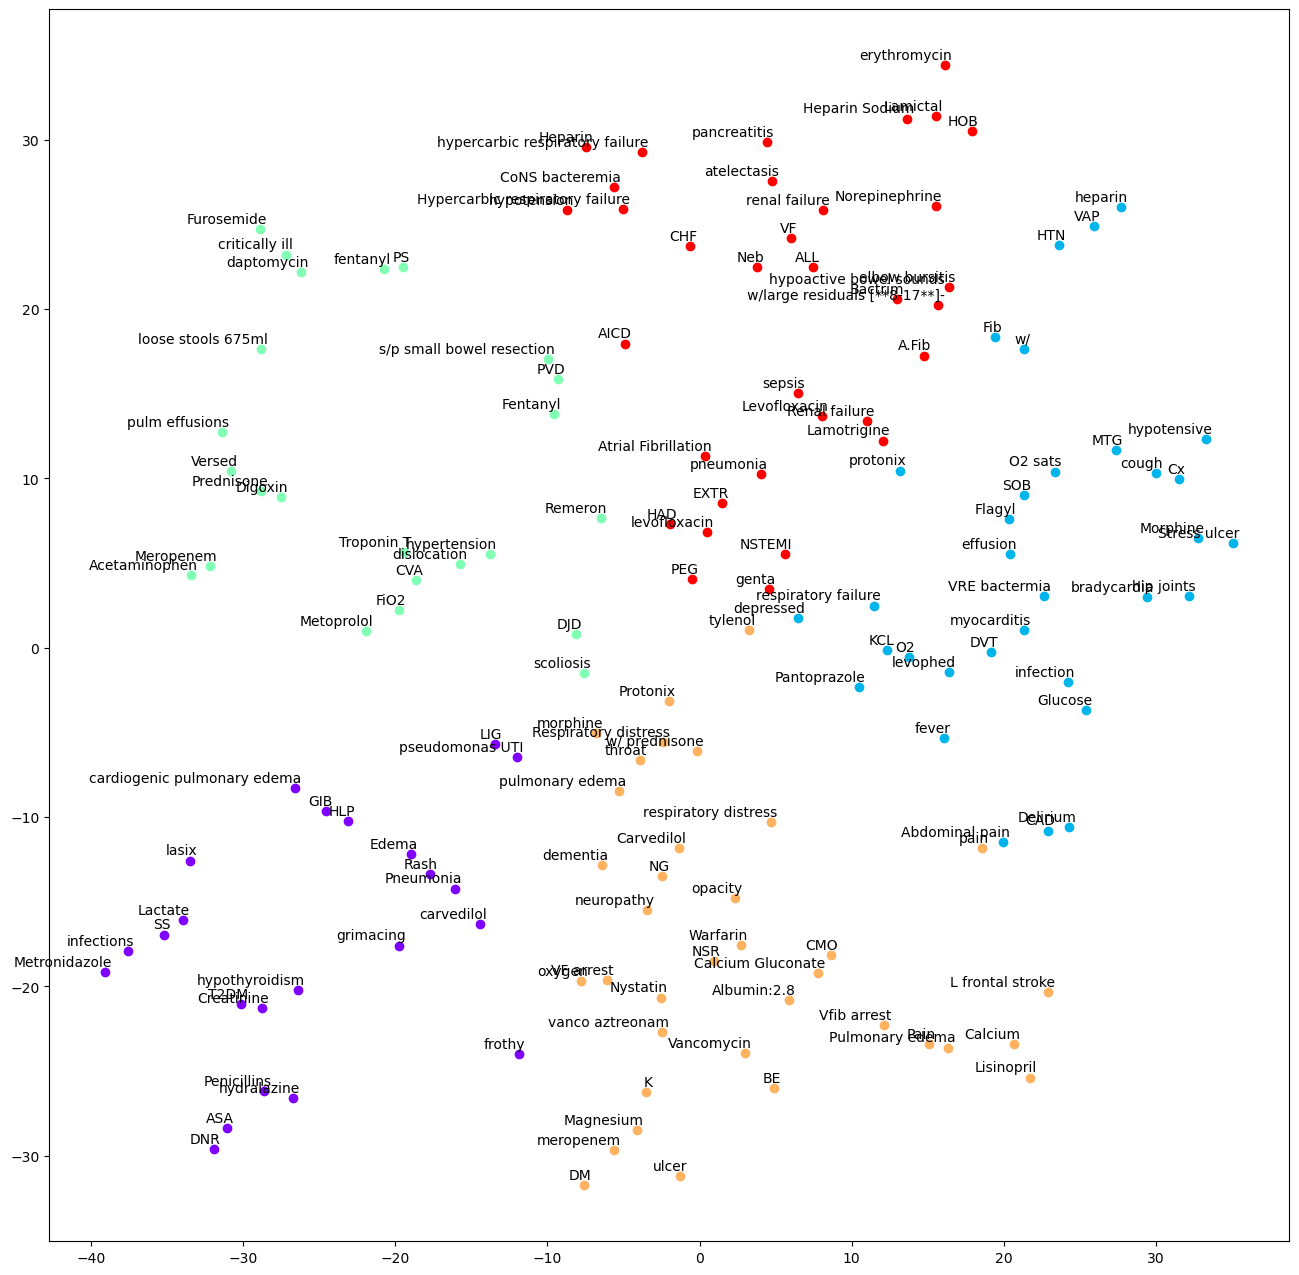

In [129]:
# Load pre-trained word2vec model
word2vec_model = Word2Vec(corpus, min_count=1)
# Visualize word embeddings using TSNE, indexed by the word2vec model's vocabulary
vocabs = word2vec_model.wv.index_to_key
new_v = list(vocabs)
tsne_plot(word2vec_model, new_v, preTrained=False, max_words=150)

# Feature prep & train/test splits

In [112]:
# Extract Features
scaler_age = MinMaxScaler()
scaler_entities = StandardScaler()

# Feature Engineering
age = data_df["normalized_age"].values.reshape(-1, 1)  # Already standardized
gender = data_df["gender"].map({"M": 0, "F": 1}).values.reshape(-1, 1)  # Binary
doc_vectors = np.vstack(data_df["doc_vector"].values)  # 300-dim vectors

# Encode Labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data_df["infection_type"].values)
num_classes = len(label_encoder.classes_)

# Convert to PyTorch tensors
X = torch.tensor(np.hstack((age, gender, doc_vectors)), dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

# Train-Test Split (Stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle Class Imbalance: Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.numpy(), y_train.numpy())

# Convert back to PyTorch tensors
X_train = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train = torch.tensor(y_train_resampled, dtype=torch.long)


## Check feature shapes

In [122]:
print(age.shape, gender.shape, doc_vectors.shape)  # Ensure all align


(122024, 1) (122024, 1) (122024, 200)


## Model Definition & params

In [ ]:
import torch.nn as nn

class InfectionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(InfectionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        return self.model(x)  # No Softmax (CrossEntropyLoss expects raw logits)

# Model Parameters
input_size = X.shape[1]
hidden_size = 128
output_size = num_classes

# Initialize Model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = InfectionClassifier(input_size, hidden_size, output_size).to(device)


## Balance classes & create dataloaders

In [115]:
# Compute class counts
class_counts = np.bincount(y_train.numpy())
total_samples = len(y_train)

# Compute sample weights directly from class counts
sample_weights = np.array([total_samples / class_counts[label] for label in y_train.numpy()])
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

# Create Weighted Sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


## Training

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward Pass, zero_grad resets gradients to zero b4 backpropagation
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == targets).sum().item()
        total += targets.size(0)

    accuracy = correct / total if total > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/5, Loss: 5042.6423, Accuracy: 0.2537
Epoch 2/5, Loss: 5043.0951, Accuracy: 0.2494
Epoch 3/5, Loss: 5043.5083, Accuracy: 0.2484
Epoch 4/5, Loss: 5044.5609, Accuracy: 0.2511
Epoch 5/5, Loss: 5045.4955, Accuracy: 0.2504


## Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate Model
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Compute accuracy
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
